<a href="https://colab.research.google.com/github/soaresedirlan/data_science/blob/master/series_temporais_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de séries temporais com o ARIMA

As séries temporais oferecem a oportunidade de prever valores futuros. Com base nos valores anteriores, as séries temporais podem ser usadas para prever tendências em economia, clima e planejamento de capacidade, para citar alguns. As propriedades específicas dos dados de séries temporais significam que geralmente são necessários métodos estatísticos especializados.

Neste tutorial, teremos como objetivo produzir previsões confiáveis ​​de séries temporais. Começaremos introduzindo e discutindo os conceitos de autocorrelação, estacionariedade e sazonalidade, e continuaremos a aplicar um dos métodos mais usados ​​para a previsão de séries temporais, conhecido como ARIMA.

Um dos métodos disponíveis no Python para modelar e prever pontos futuros de uma série temporal é conhecido como SARIMAX, que significa médias móveis integradas sazonais e auto-regressivas com regressores eXógenos. Aqui, focaremos principalmente o componente ARIMA, que é usado para ajustar dados de séries temporais para melhor entender e prever pontos futuros da série temporal.

## *Forecasting* usando ARIMA

ARIMA significa *AutoRegressive Integrated Moving Average* e é um dos modelos mais usados para fazer previsões em cima de Séries Temporais.

É uma classe de modelo que consegue capturar um conjunto de diferentes estruturas temporais dados de TS. O acrônimo ARIMA significa:

* **AR**: *Autoregression*, pois usa a relação de dependência entre uma observação e um número de *lagged observations*.
* **I**: *Integrated*, pois usa a diferenciação das observações *raw* para transformar a TS em estacionária.
* **MA**: *Moving Average*, pois usa a dependência entre uma observação e o erro residual proveniente de uma média móvel aplicada a *lagged observations*.

Cada um desses componentes são representados por um parâmetro do modelo. Por esse fato, é muito comum ver a notação $ARIMA(p, d, q)$.

Para encontrar os parâmetros otimizados de p, d, e q, usaremos as funções ACF (Autocorrelação) e PACF (Autocorrelação Parcial).

## Importando pacotes e carregando dados

In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# importar bibliotecas
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline

In [ ]:
# importar dados
df = pd.read_csv('https://raw.githubusercontent.com/carlosfab/escola-data-science/master/datasets/electricity_consumption/Electric_Production.csv')
df.DATE = pd.to_datetime(df.DATE, format="%m-%d-%Y")
df.set_index('DATE', inplace=True)
df.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


## Introdução às Séries Estacionárias

Um pré-requisito para que possamos fazer previsões em cima de uma TS é ela ser estacionária.

De maneira simplificada, ser estacionária significa ter a média, variância e covariância permanecendo constante ao longo da dimensão temporal. Vamos entender visualmente o que isso significa.

<center>
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/09/ns5-e1536673990684.png" width="50%"></center>

No primeiro plot, há uma tendência de alta. Ou seja, a sua média está aumentando conforme o tempo passa. No segundo plot, apesar de não haver uma variação na tendência, a variância (não constante) está interferindo na sua amplitude. Por fim, o último exibe o comportamento típico de quando a covariância varia em função do tempo.

**E como se pareceria uma série estacionária?**

Uma TS com média, variância e covariância constante seria parecida com o plot abaixo.

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/09/ns6-e1536674898419.png" width="20%"></center>

**Como verificar se uma TS é estacionária?**

Há muitas maneiras se fazer essa verificação. Por exemplo:

* **Olhar os plots -** Em muitos casos, durante a análise exploratória você já vai identificar visualmente se uma TS é estacionária ou não.
* **Resumo estatístico -** Você pode gerar um resumo com as principais informações estatísticas da TS, e verificar se há algum indício da estacionaridade.
* **Testes estatísticos -** São testes que possuem a capacidade de nos dizer se uma TS é estacionária ou não, sempre se baseando em métodos científicos.

Faremos um teste estatístico específico para identificar se nossa TS é estacionária ou não, o teste ***Augmented Dickey Fuller (ADF)***

### Teste ADF

Como falamos anteriormente, o ADF é um dos testes estatísticos mais usados para TS. Suas hipóteses nula e alternativa são:

* A Hipótese Nula ($H_0$) do teste é que a TS não é estacionária. Ou seja, possui algum tipo de dependência em relação ao tempo.
* A Hipótese Alternativa ($H_1$) rejeita a hipótese nula, ou seja, que a TS é estacionária.

Vamos realizar o ADF em cima do *dataset*:

In [ ]:
# importar o teste ADF
from statsmodels.tsa.stattools import adfuller 

# extrair apenas os valores
X = df.Value.values

# aplicar ADF e imprimir o resultado
result = adfuller(X)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result[0]))
print('Valor-p: {:.4f}'.format(result[1]))
print('Valores Críticos:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -2.2570
Valor-p: 0.1862
Valores Críticos:
	1%: -3.4476
	5%: -2.8692
	10%: -2.5708


Normalmente, rejeitamos $H_0$ quando o *p-value* é menor ou igual a um determinado nível de significância. Normalmente, esse nível de significância é igual a 0.01 (5%), 0.05 (5%) ou até mesmo 0.1 (10%).

Quanto menor o *p-value*, mais evidências contra a hipótese nula você tem. Por exemplo, caso seja usado $\text{p-value} = 0.05$, rejeitamos a $H_0$ com um nível de confiança de 95%. 

Caso o valor do teste fique acima do *threshold*, falharemos em rejeitar a hipótese nula. **Atenção, isso não significa que $H_0$ é verdadeira.** Significa apenas que o experimento não encontrou evidências para rejeitá-la.

### Transformando uma TS em estacionária

Para transformar uma TS em estacionária, precisamos remover a tendência e a sazonalidade que há nos dados originais. Para isso, existem diversas técnicas que podem ser usadas.

Uma bom começo é aplicar o $log$ a fim de reduzirmos a magnitude dos valores da TS. Na sequência, subtraímos a média móvel de um determinado período em relação ao $log$ da TS.

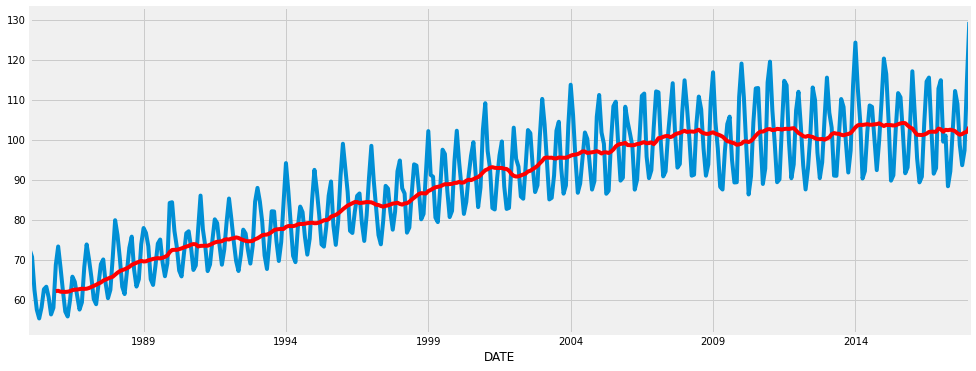

In [ ]:
#Plotar Grafico Média Movel
ma_sub = df.rolling(12).mean()
fig, ax = plt.subplots(figsize=(15, 6))
df.plot(ax=ax, legend=False)
ma_sub.plot(ax=ax, color='r', legend=False)
plt.show()



Como nosso dataset não é estacionario vamos aplicar algumas tecnicas para poder ajustar:

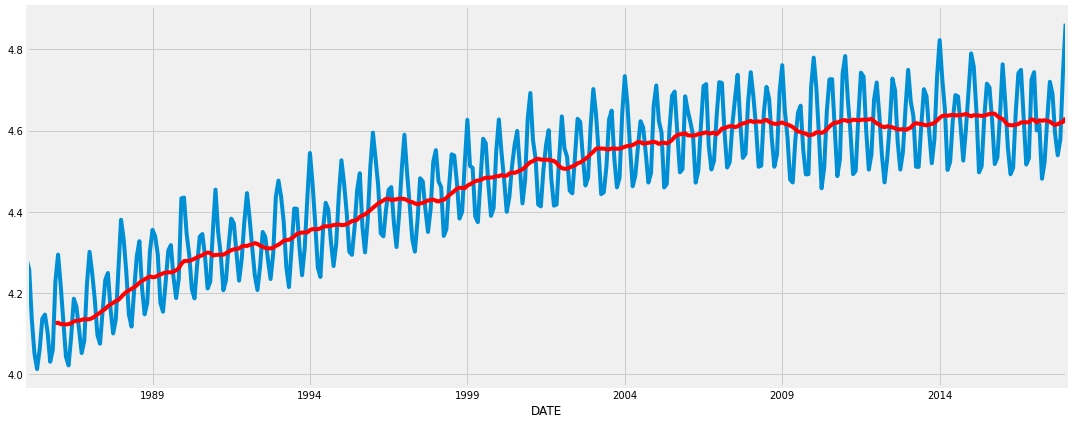

In [ ]:

# aplicar log
df_log = np.log(df)
ma_log = df_log.rolling(12).mean()

fig, ax = plt.subplots(figsize=(15, 6))
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, color='r', legend=False)
plt.tight_layout()

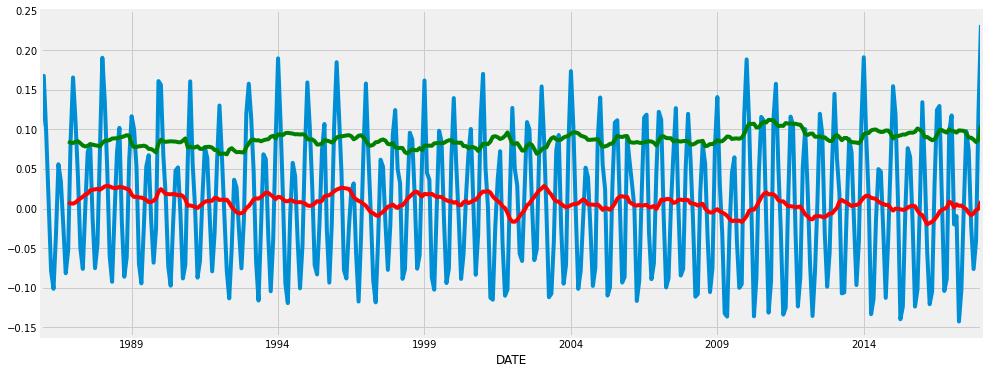

In [ ]:

# subtrair a média do log dos dados
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(12).mean()
std_sub = df_sub.rolling(12).std()

fig, ax = plt.subplots(figsize=(15, 6))
df_sub.plot(ax=ax, legend=False)
ma_sub.plot(ax=ax, color='r', legend=False)
std_sub.plot(ax=ax, color='g', legend=False)
plt.show()

In [ ]:
# repetir o ADF
X_sub = df_sub.Value.values

# aplicar ADF e imprimir o resultado
result_sub = adfuller(X_sub)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_sub[0]))
print('Valor-p: {:.10f}'.format(result_sub[1]))
print('Valores Críticos:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -5.2116
Valor-p: 0.0000083256
Valores Críticos:
	1%: -3.4481
	5%: -2.8694
	10%: -2.5709


Diferenciação
Uma outra técnica simples que ajuda a tornar TS mais estacionárias é a diferenciação.

Apenas calculando a diferença entre duas observações possíveis, é possível incrementar ainda mais o desempenho no ADF.

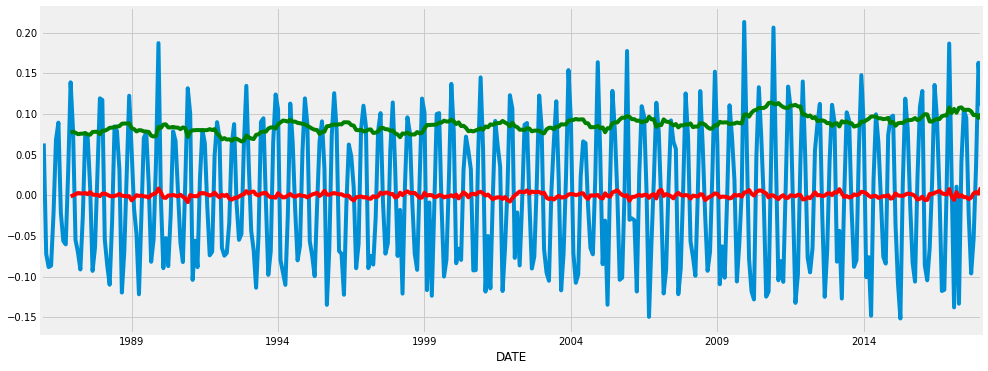

Dickey-Fuller Aumentado
Teste Estatístico: -7.6511
Valor-p: 0.0000000000
Valores Críticos:
	1%: -3.4483
	5%: -2.8694
	10%: -2.5710


In [ ]:

# aplicar diferenciação
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

fig, ax = plt.subplots(figsize=(15, 6))
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, color='r', legend=False)
std_diff.plot(ax=ax, color='g', legend=False)
plt.show()

# extrair apenas os valores
X_diff = df_diff.Value.dropna().values

# aplicar ADF e imprimir o resultado
result_diff = adfuller(X_diff)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_diff[0]))
print('Valor-p: {:.10f}'.format(result_diff[1]))
print('Valores Críticos:')
for key, value in result_diff[4].items():
	print('\t{}: {:.4f}'.format(key, value))


Tambem usaremos uma "pesquisa em grade" para explorar iterativamente diferentes combinações de parâmetros. Para cada combinação de parâmetros, ajustamos um novo modelo ARIMA sazonal com a SARIMAX() função do statsmodels e avaliamos sua qualidade geral. Depois de explorarmos todo o cenário de parâmetros, nosso conjunto ideal de parâmetros será aquele que produzirá o melhor desempenho para nossos critérios de interesse. Vamos começar gerando as várias combinações de parâmetros que queremos avaliar:

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Agora podemos usar os triplos parâmetros definidos acima para automatizar o processo de treinamento e avaliação dos modelos ARIMA em diferentes combinações Estatística e Machine Learning, esse processo é conhecido como pesquisa em grade (ou otimização de hiperparâmetro) para seleção de modelo.

Ao avaliar e comparar modelos estatísticos ajustados com parâmetros diferentes, cada um pode ser classificado um com o outro, com base na adequação dos dados ou na capacidade de prever com precisão pontos de dados futuros.

Usaremos o valor AIC(Critério de informação de Akaike), que é convenientemente retornado com os modelos ARIMA instalados statsmodels.

As AICmedidas de quão bem um modelo se ajusta aos dados, tendo em conta a complexidade geral do modelo. Um modelo que se adapta muito bem aos dados enquanto utiliza muitos recursos receberá uma pontuação AIC maior do que um modelo que use menos recursos para obter a mesma qualidade de ajuste.

Portanto, estamos interessados ​​em encontrar o modelo que produz o menor AICvalor.

O pedaço de código abaixo itera através de combinações de parâmetros e usa a SARIMAXfunção from statsmodelspara ajustar o modelo sazonal ARIMA correspondente.

Aqui, o orderargumento especifica os (p, d, q)parâmetros, enquanto o seasonal_orderargumento especifica o (P, D, Q, S)componente sazonal do modelo sazonal ARIMA. Após o ajuste de cada SARIMAX()modelo, o código imprime sua respectiva AICpontuação.

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Como algumas combinações de parâmetros podem levar a especificações numéricas incorretas, desabilitamos explicitamente as mensagens de aviso para evitar uma sobrecarga de mensagens de aviso. 

Essas especificações incorretas também podem levar a erros e gerar uma exceção, portanto, capturamos essas exceções e ignoramos as combinações de parâmetros que causam esses problemas.


Usando a pesquisa em grade, identificamos o conjunto de parâmetros que produz o melhor modelo de ajuste para nossos dados de séries temporais. Podemos continuar analisando esse modelo em particular com mais profundidade.

Começaremos inserindo os valores ideais dos parâmetros em um novo SARIMAXMODEL:

In [ ]:
mod = sm.tsa.statespace.SARIMAX(df_diff,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2084      0.049     -4.236      0.000      -0.305      -0.112
ma.L1         -1.0000     49.754     -0.020      0.984     -98.517      96.517
ar.S.L12       0.0330      0.065      0.506      0.613      -0.095       0.161
ma.S.L12      -0.8482      0.045    -18.974      0.000      -0.936      -0.761
sigma2         0.0006      0.032      0.020      0.984      -0.062       0.063


O summary que resulta da saída de SARIMAX retorna uma quantidade significativa de informações, mas focaremos nossa atenção na tabela de coeficientes.

A coef coluna mostra o peso (ou seja, importância) de cada recurso e como cada um deles afeta a série temporal. A P>|z|coluna nos informa a importância de cada peso de recurso. Aqui, cada peso tem um valor p menor ou próximo a 0.05, portanto, é razoável reter todos eles em nosso modelo.

Ao ajustar modelos ARIMA sazonais (e quaisquer outros modelos), é importante executar o diagnóstico do modelo para garantir que nenhuma das suposições feitas pelo modelo tenha sido violada. O plot_diagnostics nos permite gerar rapidamente diagnósticos de modelo e investigar qualquer comportamento incomum.

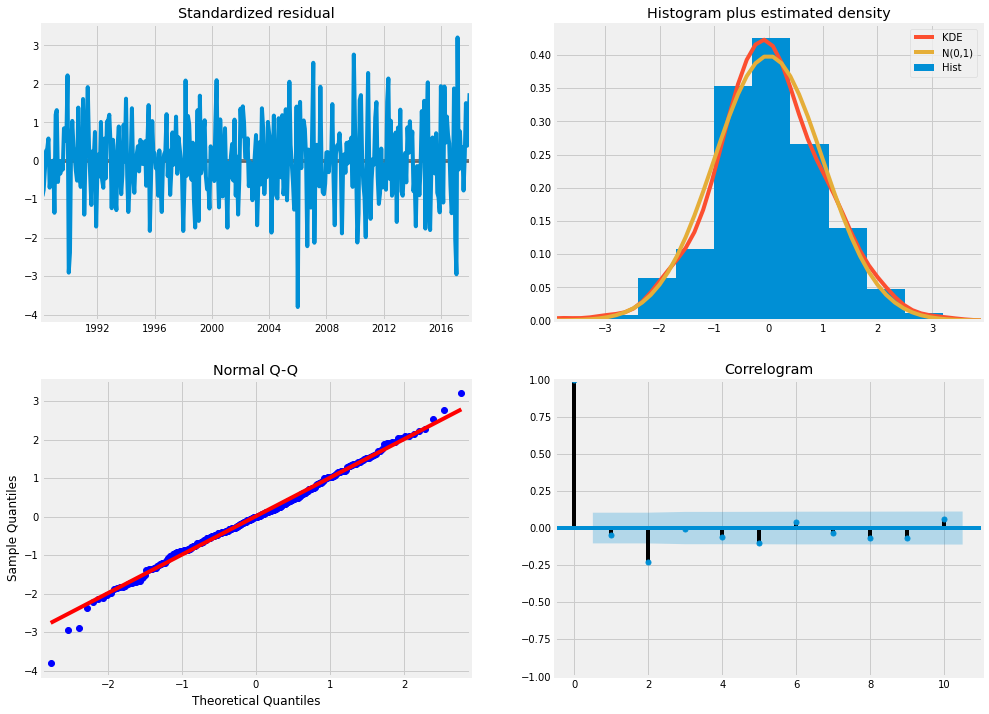

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Nossa principal preocupação é garantir que os resíduos de nosso modelo não sejam correlacionados e normalmente distribuídos com média zero.

Se o modelo ARIMA sazonal não atender a essas propriedades, é uma boa indicação de que pode ser melhorado ainda mais.

Nesse caso, nosso diagnóstico de modelo sugere que os resíduos do modelo são normalmente distribuídos com base no seguinte:

No gráfico superior direito, vemos que a KDElinha vermelha segue de perto a N(0,1)linha (onde N(0,1)) é a notação padrão para uma distribuição normal com média 0e desvio padrão de 1). 

Essa é uma boa indicação de que os resíduos são normalmente distribuídos.
O gráfico qq no canto inferior esquerdo mostra que a distribuição ordenada de resíduos (pontos azuis) segue a tendência linear das amostras retiradas de uma distribuição normal padrão com N(0, 1).

Novamente, essa é uma forte indicação de que os resíduos são normalmente distribuídos.

Os resíduos ao longo do tempo (gráfico superior esquerdo) não exibem nenhuma sazonalidade óbvia e parecem ser ruído branco.

Isso é confirmado pelo gráfico de autocorrelação no canto inferior direito, que mostra que os resíduos da série temporal têm baixa correlação com versões atrasadas de si mesmas.

Essas observações nos levam a concluir que nosso modelo produz um ajuste satisfatório que pode nos ajudar a entender nossos dados de séries temporais e prever valores futuros.

Embora tenhamos um ajuste satisfatório, alguns parâmetros de nosso modelo ARIMA sazonal podem ser alterados para melhorar nosso ajuste.

Por exemplo, nossa pesquisa na grade considerou apenas um conjunto restrito de combinações de parâmetros; portanto, podemos encontrar melhores modelos se ampliarmos a pesquisa na grade.

Outra posibilidade de avaliar podemos analisar alguns metodos como ACR e PACF.

In [ ]:
# melhores parâmetros para o nosso modelo
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_diff.dropna(), nlags=25)
lag_pacf = pacf(df_diff.dropna(), nlags=25)

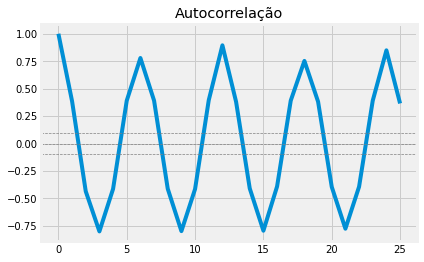

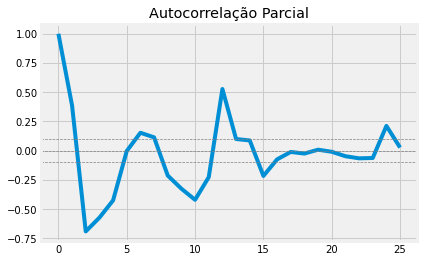

In [ ]:
# plotar ACR e PACF
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=-1.96 / np.sqrt((len(df) - 1)), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=1.96 / np.sqrt((len(df) - 1)), linestyle='--', color='gray', linewidth=0.7)
plt.title("Autocorrelação")
plt.show()

plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=-1.96 / np.sqrt((len(df) - 1)), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=1.96 / np.sqrt((len(df) - 1)), linestyle='--', color='gray', linewidth=0.7)
plt.title("Autocorrelação Parcial")
plt.show()

Os valores otimizados dos parâmetros do ARIMA são identificados ao olharmos os plots acima:

* **q:** valor onde a ACF cruza o limite superior do intervalo de confiança pela primeira vez. 
* **p:** valor onde o PACF cruza o limite superor do intervalo de confiança pela primeira vez.

Vamos agora construir o modelo ARIMA.

## Ajustando um modelo de série temporal ARIMA



In [ ]:

# treinar o modelo ARIMA
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(2, 1, 2))
result_AR = model.fit()

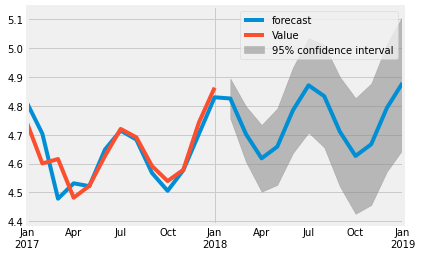

In [ ]:
# start="2017-01-01", end="2019-01-01"
result_AR.plot_predict(start="2017-01-01", end="2019-01-01");